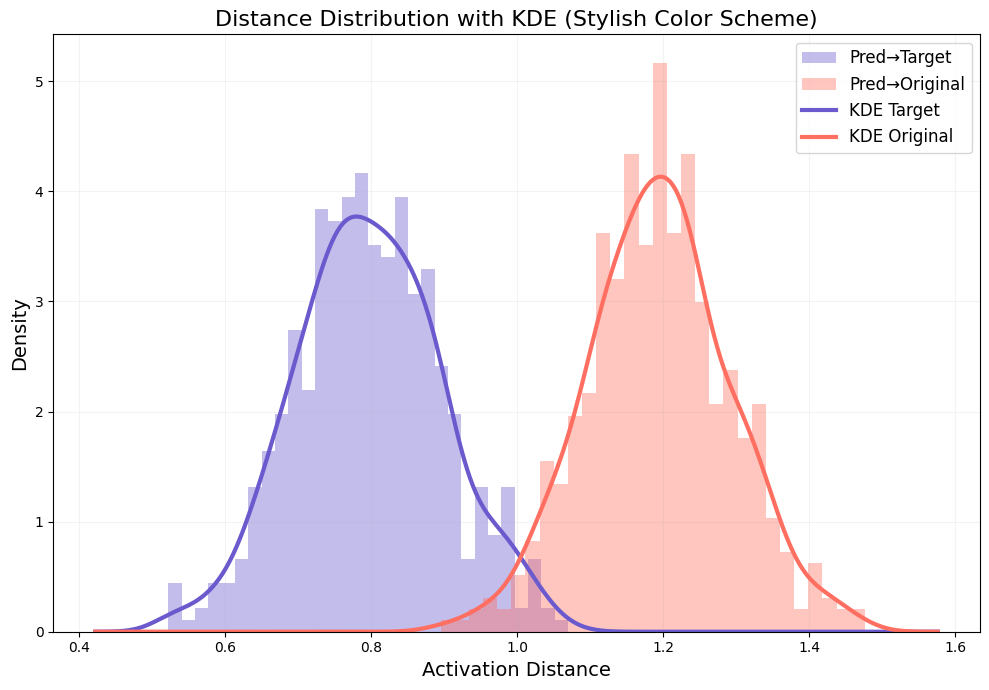

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Simulate distances
np.random.seed(0)
dist_pred_target = np.random.normal(loc=0.8, scale=0.1, size=500)
dist_pred_original = np.random.normal(loc=1.2, scale=0.1, size=500)

# KDE curves
kde_target = gaussian_kde(dist_pred_target)
kde_original = gaussian_kde(dist_pred_original)

x_min = min(dist_pred_target.min(), dist_pred_original.min()) - 0.1
x_max = max(dist_pred_target.max(), dist_pred_original.max()) + 0.1
xs = np.linspace(x_min, x_max, 300)

plt.figure(figsize=(10,7))

# Stylish pastel colors
target_color = "#6A5ACD"   # SlateBlue
orig_color = "#FF6F61"     # Coral

# Histograms
plt.hist(dist_pred_target, bins=30, density=True, alpha=0.4, color=target_color, label='Pred→Target')
plt.hist(dist_pred_original, bins=30, density=True, alpha=0.4, color=orig_color, label='Pred→Original')

# KDE curves (smooth with stylish colors)
plt.plot(xs, kde_target(xs), linewidth=3, color=target_color, label='KDE Target')
plt.plot(xs, kde_original(xs), linewidth=3, color=orig_color, label='KDE Original')

# Fancy aesthetics
plt.xlabel("Activation Distance", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.title("Distance Distribution with KDE (Stylish Color Scheme)", fontsize=16)

plt.grid(alpha=0.15)
plt.legend(fontsize=12)
plt.tight_layout()